In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
obj = qs::qread('../00_preprocessing/_targets/objects/exp_neuron_obob')
obj

Loading required package: SeuratObject

Attaching sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Loading required package: Seurat


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




An object of class Seurat 
59227 features across 86815 samples within 3 assays 
Active assay: SCT (26906 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [3]:
obj@meta.data = obj@meta.data %>% mutate(batch = stringr::str_replace_all(batch, stringr::fixed(" "), '__'))
obj@meta.data$group = interaction(obj@meta.data$treatment, obj@meta.data$time)

In [4]:
sce = as.SingleCellExperiment(obj)
sce

class: SingleCellExperiment 
dim: 26906 86815 
metadata(0):
assays(2): counts logcounts
rownames(26906): ENSMUSG00000089699 ENSMUSG00000104238 ...
  ENSMUSG00000095263 LOC665290
rowData names(0):
colnames(86815): GCAGCCACACAGCCAC_1_1 TGCTTGCAGTTCCGTA_1_1 ...
  TGGAGGAAGCGGTAGT_5_3 TGATTCTGTGCCGTTG_5_3
colData names(38): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: SCT
altExpNames(2): RNA integrated

In [5]:
# reducedDim(sce, "PCA", withDimnames=TRUE) <- obj[['pca']]@cell.embeddings

In [6]:
# sce <- runUMAP(sce, dimred='PCA', name = 'UMAP', n_dimred = 30)

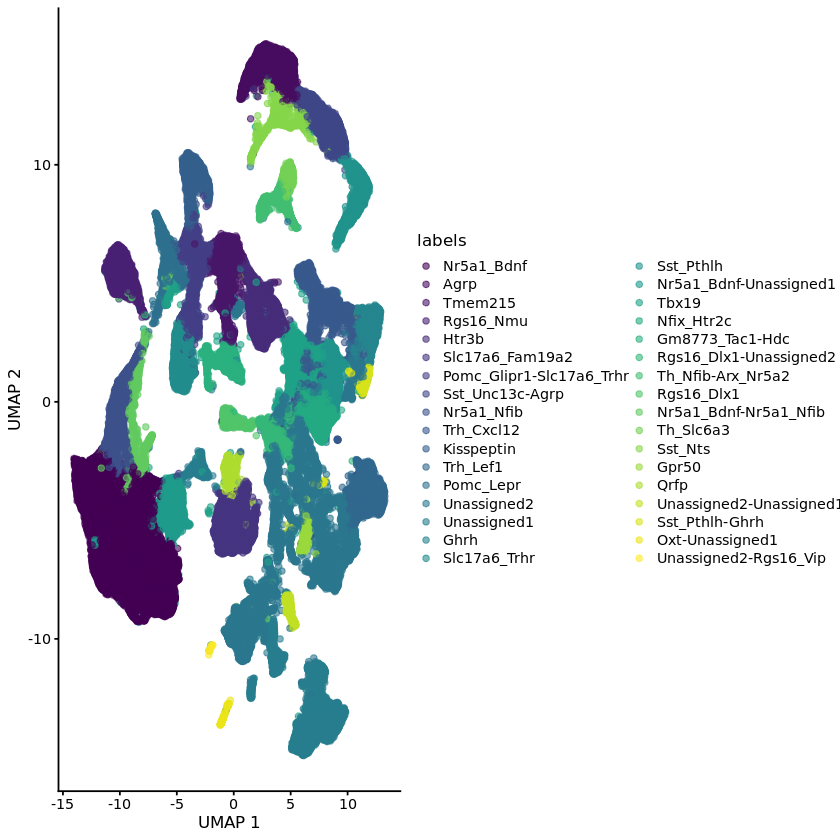

In [7]:
plotReducedDim(sce, colour_by = 'labels', dimred='UMAP')

In [8]:
obob_milo <- Milo(sce)

#build KNN graph
obob_milo <- buildGraph(obob_milo, k=40, d=30, reduced.dim = 'PCA')

#define neighbourhoods
obob_milo <- makeNhoods(obob_milo, prop = 0.1, k= 40, d=30, refined = T, reduced_dims = 'PCA')

Constructing kNN graph with k:40

Checking valid object

Running refined sampling with reduced_dim



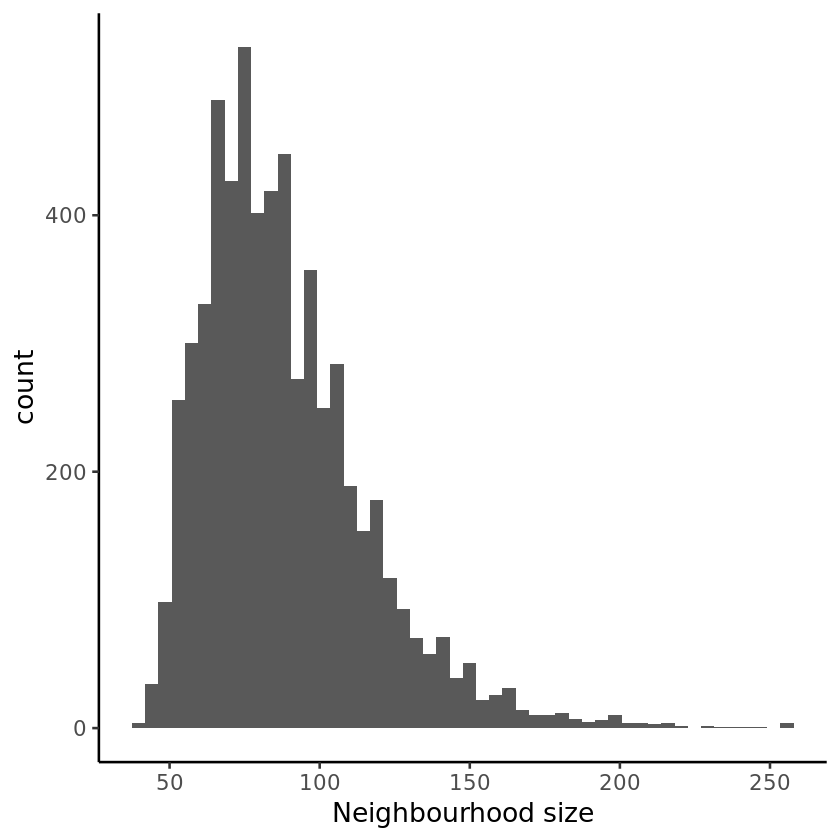

In [9]:
#plot neighbourhood sizes to check if we used appropriate k for graph building
  #we want to have an average size over 5 x N_samples
  #we have 171 samples - but not all samples will be in all neighbourhoods because of age variance
plotNhoodSizeHist(obob_milo)

Checking meta.data validity

Counting cells in neighbourhoods



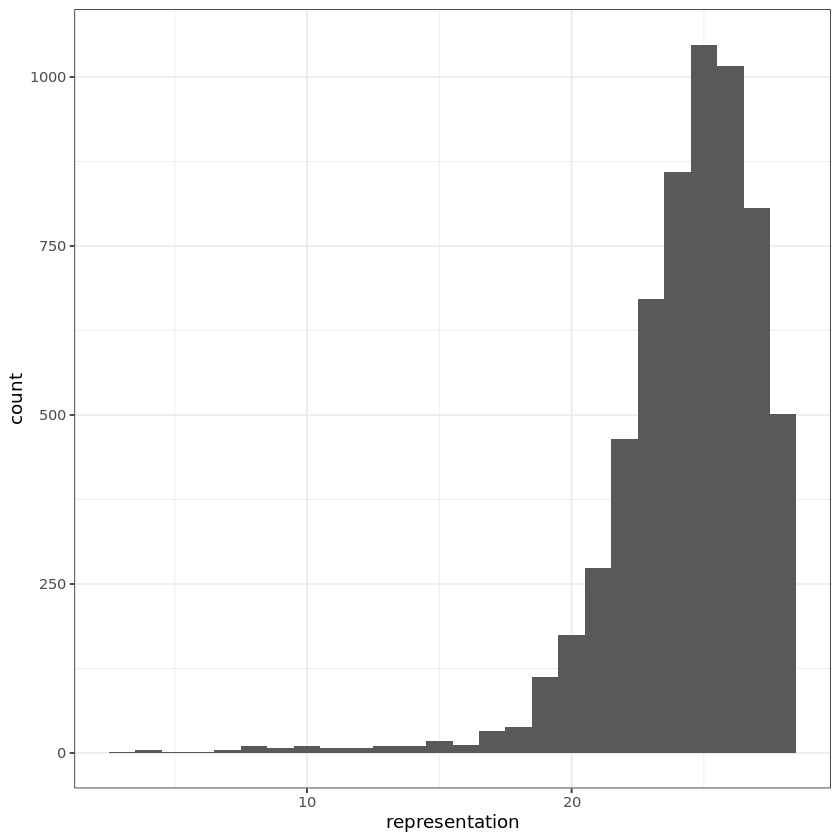

In [10]:
#add a n x m matrix to the milo object with number of neighbourhodds and samples
obob_milo <- countCells(obob_milo, meta.data = as.data.frame(colData(obob_milo)), sample = 'hash.mcl.ID')

#calculate sample representation in each neighbourhood
cell_counts <- as.data.frame(nhoodCounts(obob_milo)) %>% mutate(representation = rowSums(.>0))

#view distribution of N_samples in each neigbourhood
ggplot(cell_counts, aes(x = representation)) + 
  geom_histogram(binwidth = 1) + theme_bw()

#most neighbourhoods have 30-60 samples in them

In [11]:
obob_design <- data.frame(colData(obob_milo))[, c('hash.mcl.ID', 'group', 'batch')]
#convert seq-pool to factor
obob_design$batch <- as.factor(obob_design$batch)
#keep unique rows
obob_design <- distinct(obob_design)
#change rownames
rownames(obob_design) <- obob_design$hash.mcl.ID
head(obob_design)

hash.mcl.ID group        batch   
M9  M9          FGF1.Day5    Batch__1
J2  J2          Veh_PF.Day14 Batch__1
N7  N7          FGF1.Day5    Batch__1
M8  M8          Veh_PF.Day5  Batch__1
N8  N8          Veh_PF.Day5  Batch__1
M13 M13         FGF1.Day14   Batch__1

In [12]:
print(obob_design)

    hash.mcl.ID        group    batch
M9           M9    FGF1.Day5 Batch__1
J2           J2 Veh_PF.Day14 Batch__1
N7           N7    FGF1.Day5 Batch__1
M8           M8  Veh_PF.Day5 Batch__1
N8           N8  Veh_PF.Day5 Batch__1
M13         M13   FGF1.Day14 Batch__1
M24         M24 Veh_PF.Day14 Batch__1
J11         J11   FGF1.Day14 Batch__1
J16         J16   FGF1.Day14 Batch__2
M11         M11  Veh_PF.Day5 Batch__2
M23         M23   FGF1.Day14 Batch__2
N17         N17    FGF1.Day5 Batch__2
M25         M25 Veh_PF.Day14 Batch__2
M27         M27   FGF1.Day14 Batch__2
N12         N12  Veh_PF.Day5 Batch__2
J7           J7 Veh_PF.Day14 Batch__2
M29         M29 Veh_PF.Day14 Batch__2
M10         M10    FGF1.Day5 Batch__2
N21         N21    FGF1.Day5 Batch__3
N13         N13  Veh_PF.Day5 Batch__3
J10         J10 Veh_PF.Day14 Batch__3
M30         M30 Veh_PF.Day14 Batch__3
N26         N26    FGF1.Day5 Batch__3
M14         M14  Veh_PF.Day5 Batch__3
M28         M28   FGF1.Day14 Batch__3
J18         

In [13]:
length(unique(obob_design$group))

[1] 4

In [14]:
dput(unique(obob_design$group))

structure(c(3L, 2L, 4L, 1L), .Label = c("FGF1.Day14", "Veh_PF.Day14", 
"FGF1.Day5", "Veh_PF.Day5"), class = "factor")


In [ ]:
#store distances to nearest neighbours
# obob_milo <- calcNhoodDistance(obob_milo, d=30, reduced.dim = 'PCA')
# qs::qsave(obob_milo, 'obob_milo_neuron.qs')
obob_milo = qs::qread('obob_milo_neuron.qs')

In [121]:
contrast.all = c("groupVeh_PF.Day14-groupVeh_PF.Day5")
model <- model.matrix(~0 + group, data=obob_design)
mod.contrast <- makeContrasts(contrasts=contrast.all, levels=model)
head(model)

groupFGF1.Day14 groupVeh_PF.Day14 groupFGF1.Day5 groupVeh_PF.Day5
M9  0               0                 1              0               
J2  0               1                 0              0               
N7  0               0                 1              0               
M8  0               0                 0              1               
N8  0               0                 0              1               
M13 1               0                 0              0

In [122]:
options(width=120) 
print(model)

    groupFGF1.Day14 groupVeh_PF.Day14 groupFGF1.Day5 groupVeh_PF.Day5
M9                0                 0              1                0
J2                0                 1              0                0
N7                0                 0              1                0
M8                0                 0              0                1
N8                0                 0              0                1
M13               1                 0              0                0
M24               0                 1              0                0
J11               1                 0              0                0
J16               1                 0              0                0
M11               0                 0              0                1
M23               1                 0              0                0
N17               0                 0              1                0
M25               0                 1              0                0
M27               1 

In [123]:
print(mod.contrast)

                   Contrasts
Levels              groupVeh_PF.Day14-groupVeh_PF.Day5
  groupFGF1.Day14                                    0
  groupVeh_PF.Day14                                  1
  groupFGF1.Day5                                     0
  groupVeh_PF.Day5                                  -1


In [133]:
# da_results <- testNhoods(obob_milo, design = model, design.df = obob_design) #works!
da_results <- testNhoods(obob_milo, design = model, design.df = obob_design, model.contrasts = c("groupFGF1.Day5-groupVeh_PF.Day5"))

da_results %>%
  arrange(SpatialFDR) %>%
  head()

table(da_results$FDR < 0.1)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



logFC     logCPM   F        PValue       FDR          Nhood SpatialFDR  
2123  6.324723 7.923779 54.39264 9.049160e-10 5.522703e-06 2123  7.176911e-06
5673  6.025380 7.805042 44.74494 1.205856e-08 3.679669e-05 5673  5.214957e-05
4168  4.083695 7.938276 31.24776 5.613858e-07 1.142046e-03 4168  1.616667e-03
3058  4.145917 7.723501 30.10084 8.318644e-07 1.269217e-03 3058  1.878557e-03
5264 -3.427141 8.090665 28.95162 1.240333e-06 1.513951e-03 5264  1.971517e-03
4044  3.070317 7.988379 24.82681 5.455287e-06 4.756231e-03 4044  6.224051e-03


FALSE  TRUE 
 5939   164 

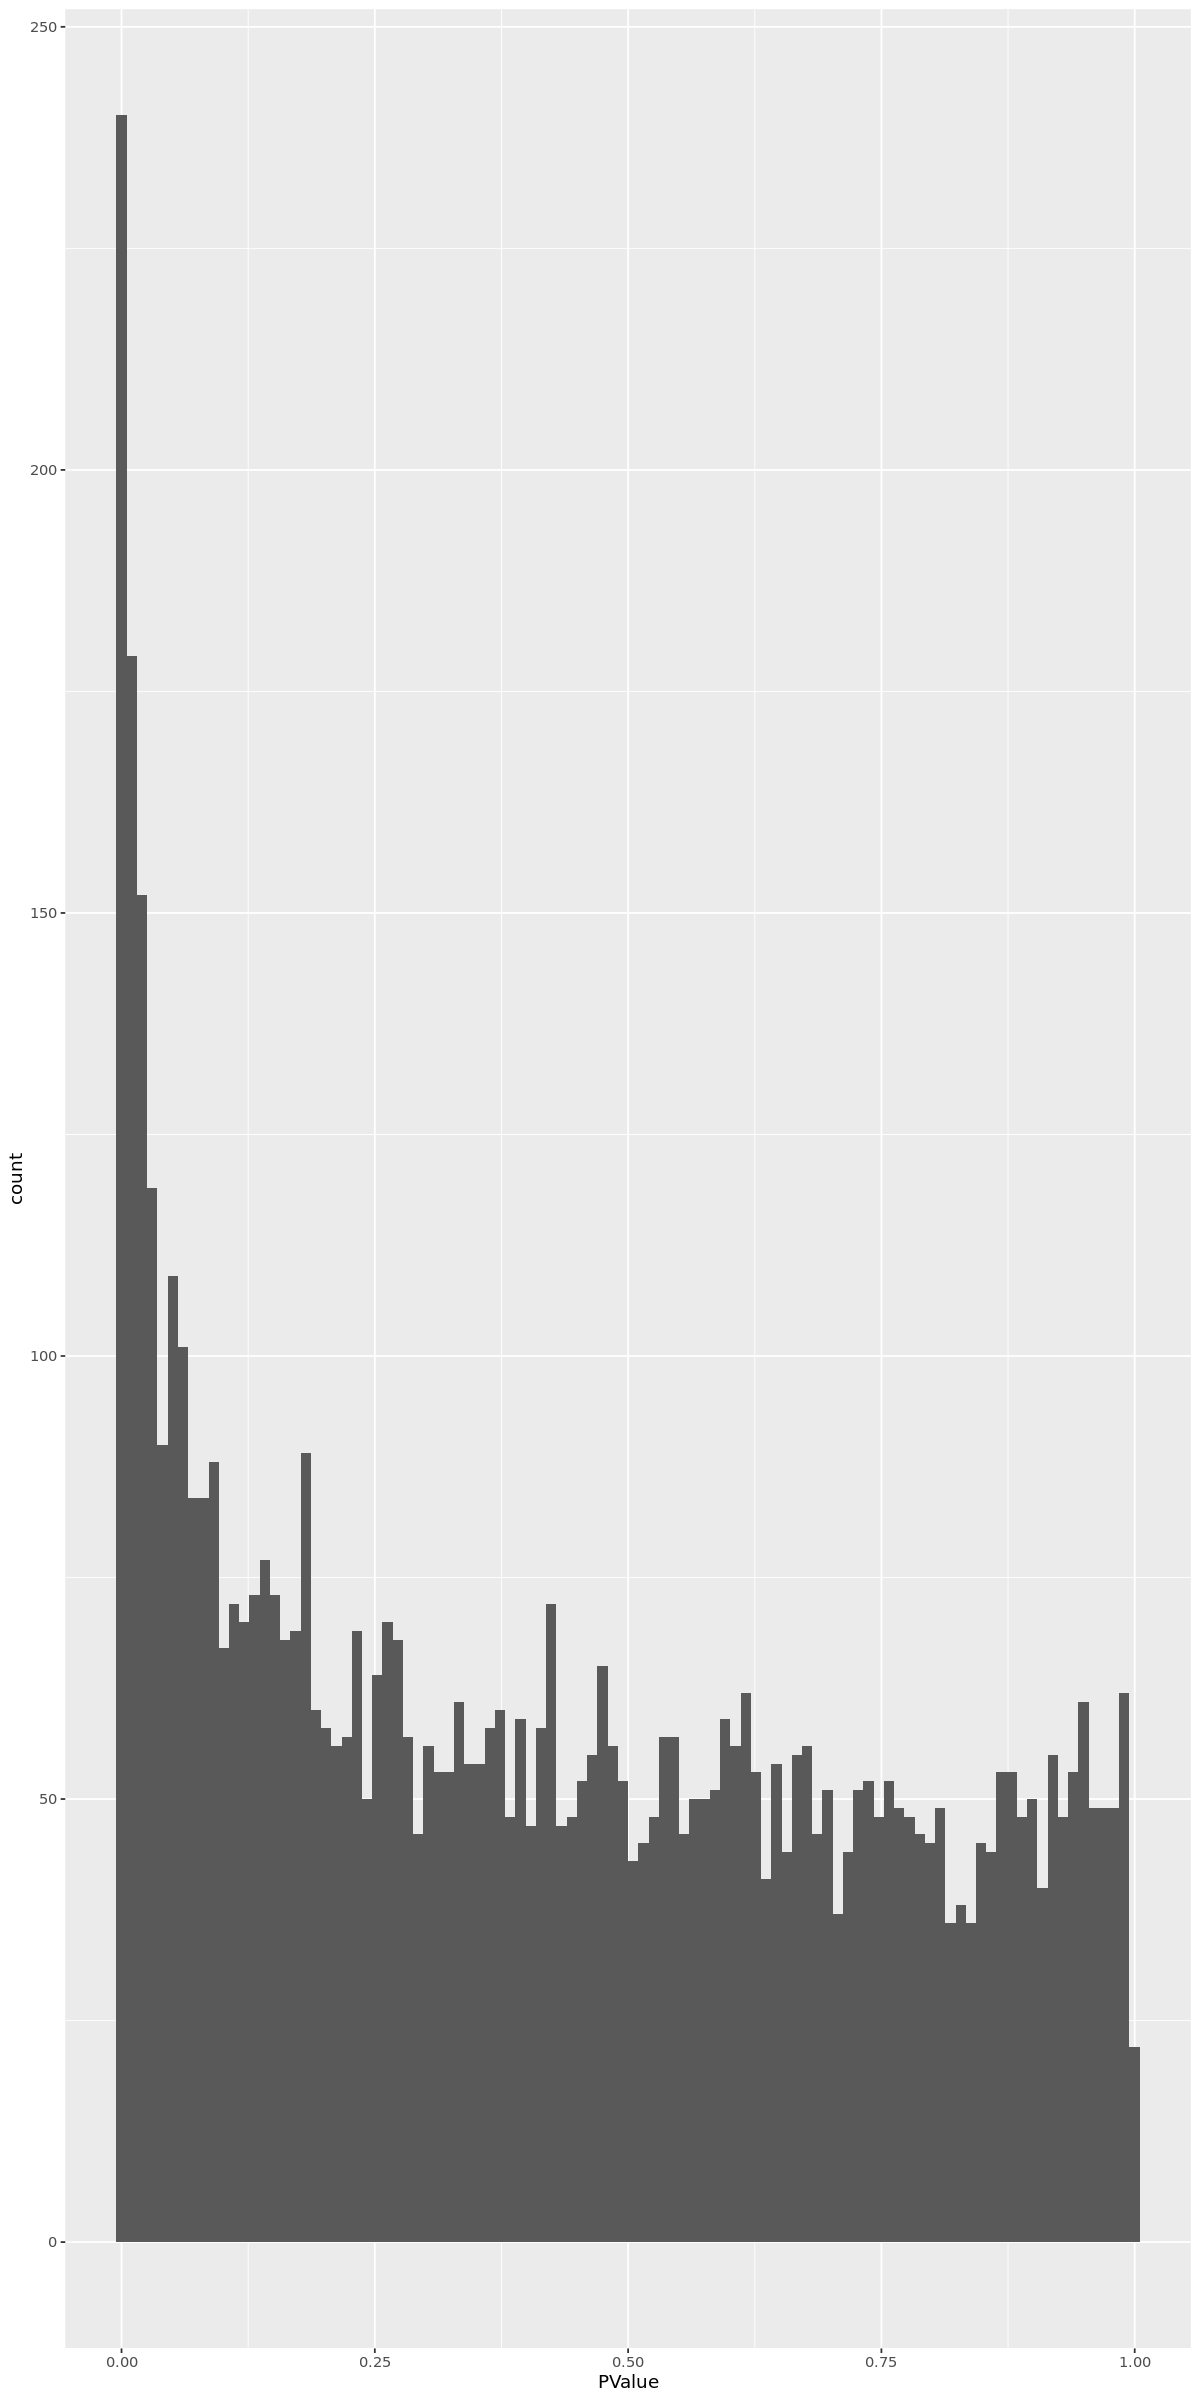

In [134]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=100)

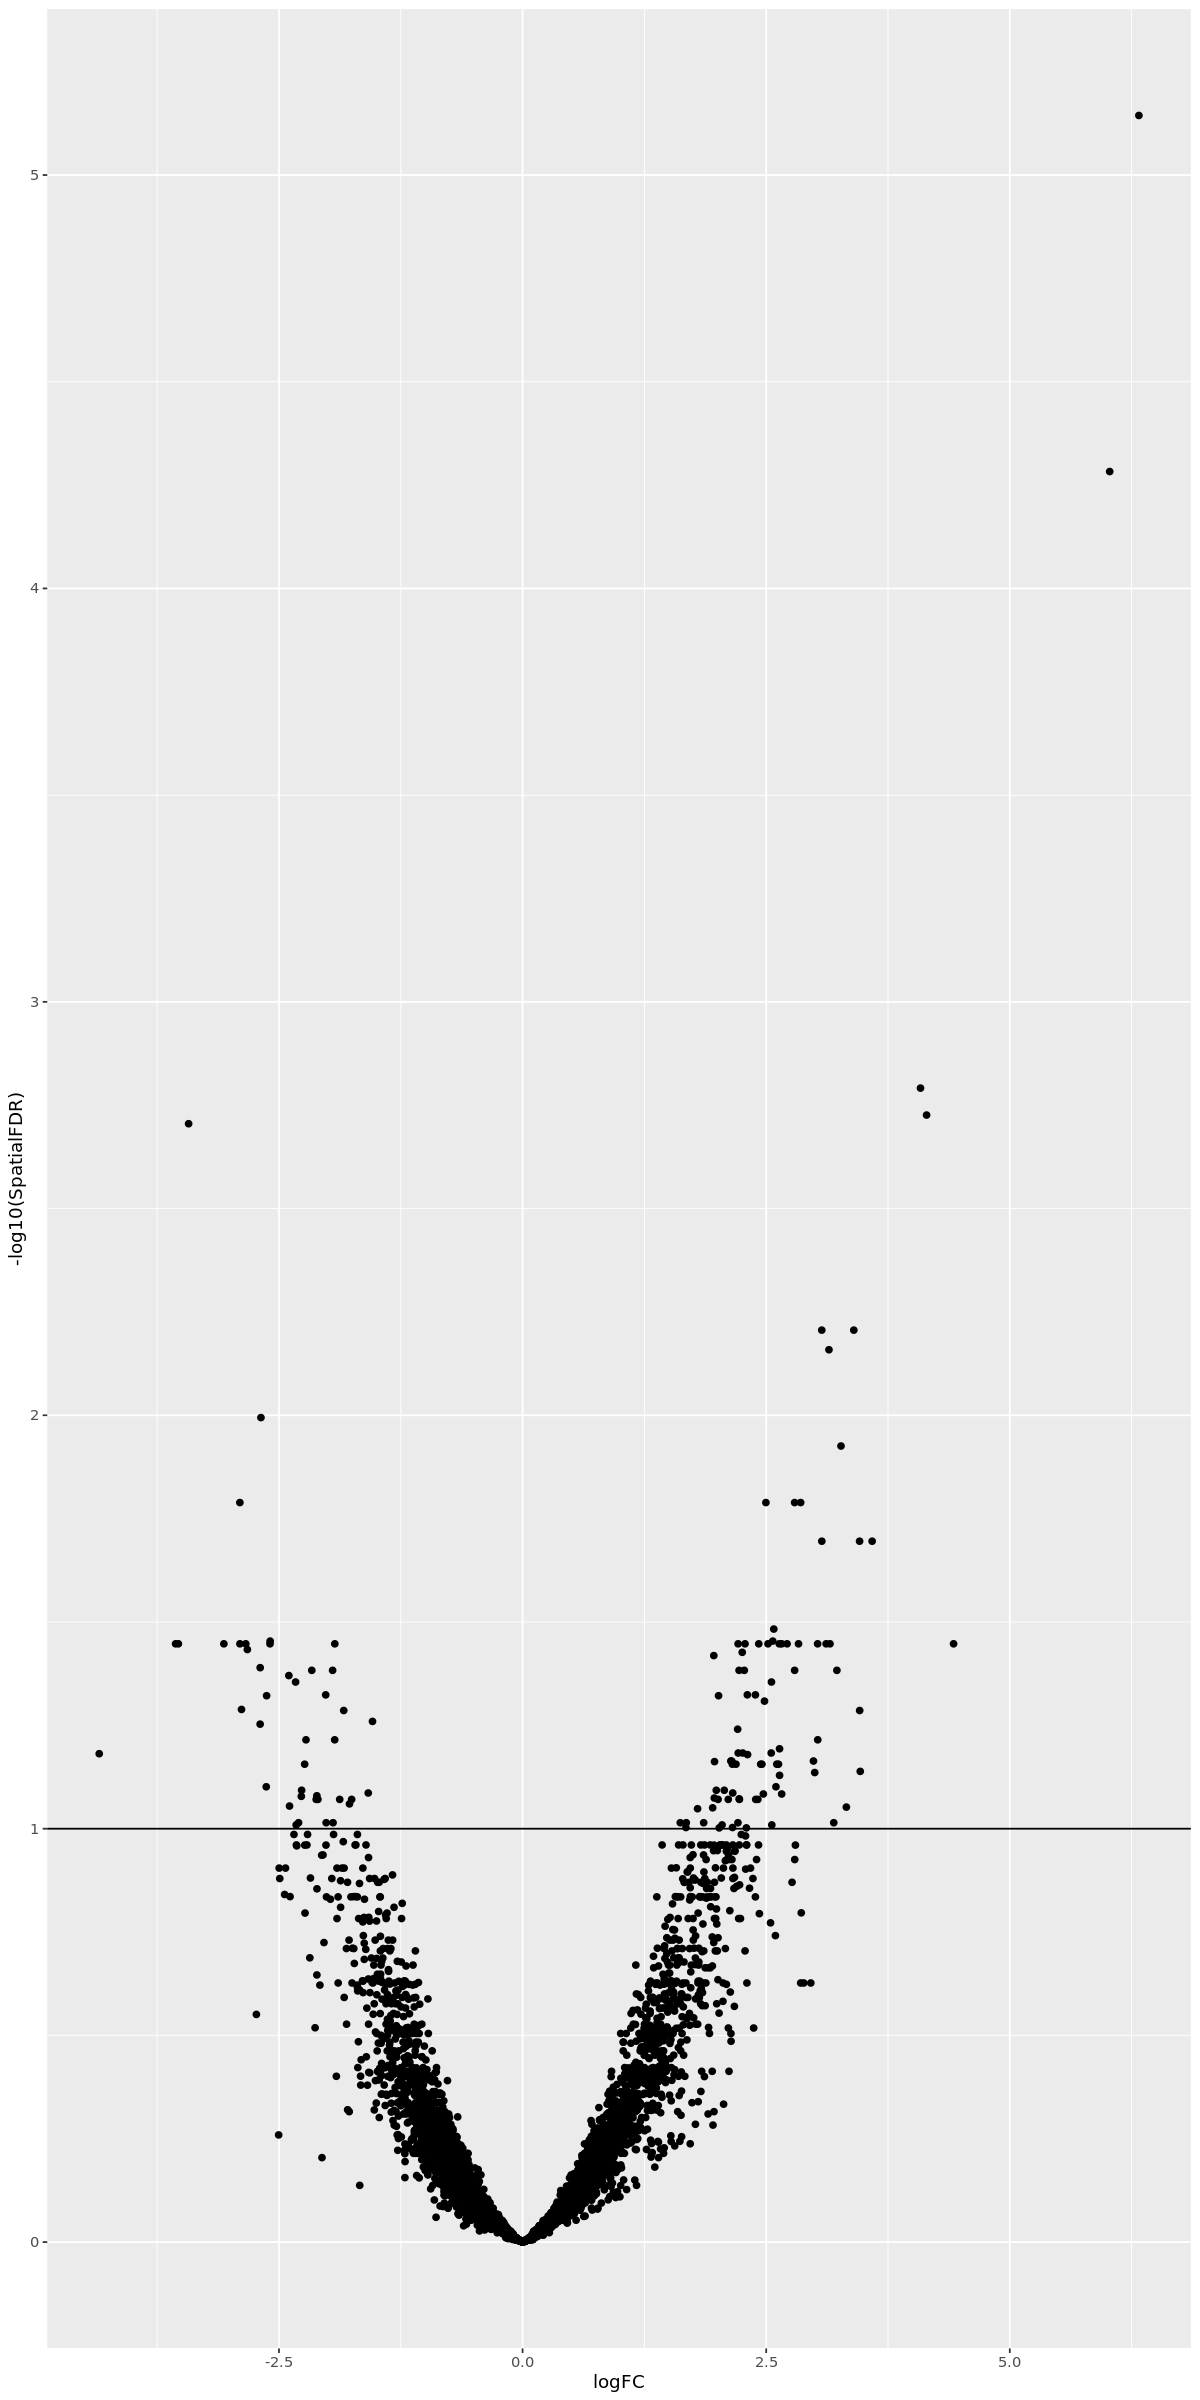

In [135]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [136]:
obob_milo <- buildNhoodGraph(obob_milo)

In [ ]:
head(data.frame(colData(obob_milo)))

In [85]:
umap_pl <- plotReducedDim(obob_milo, dimred = "UMAP", colour_by="labels", text_by = "labels", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")

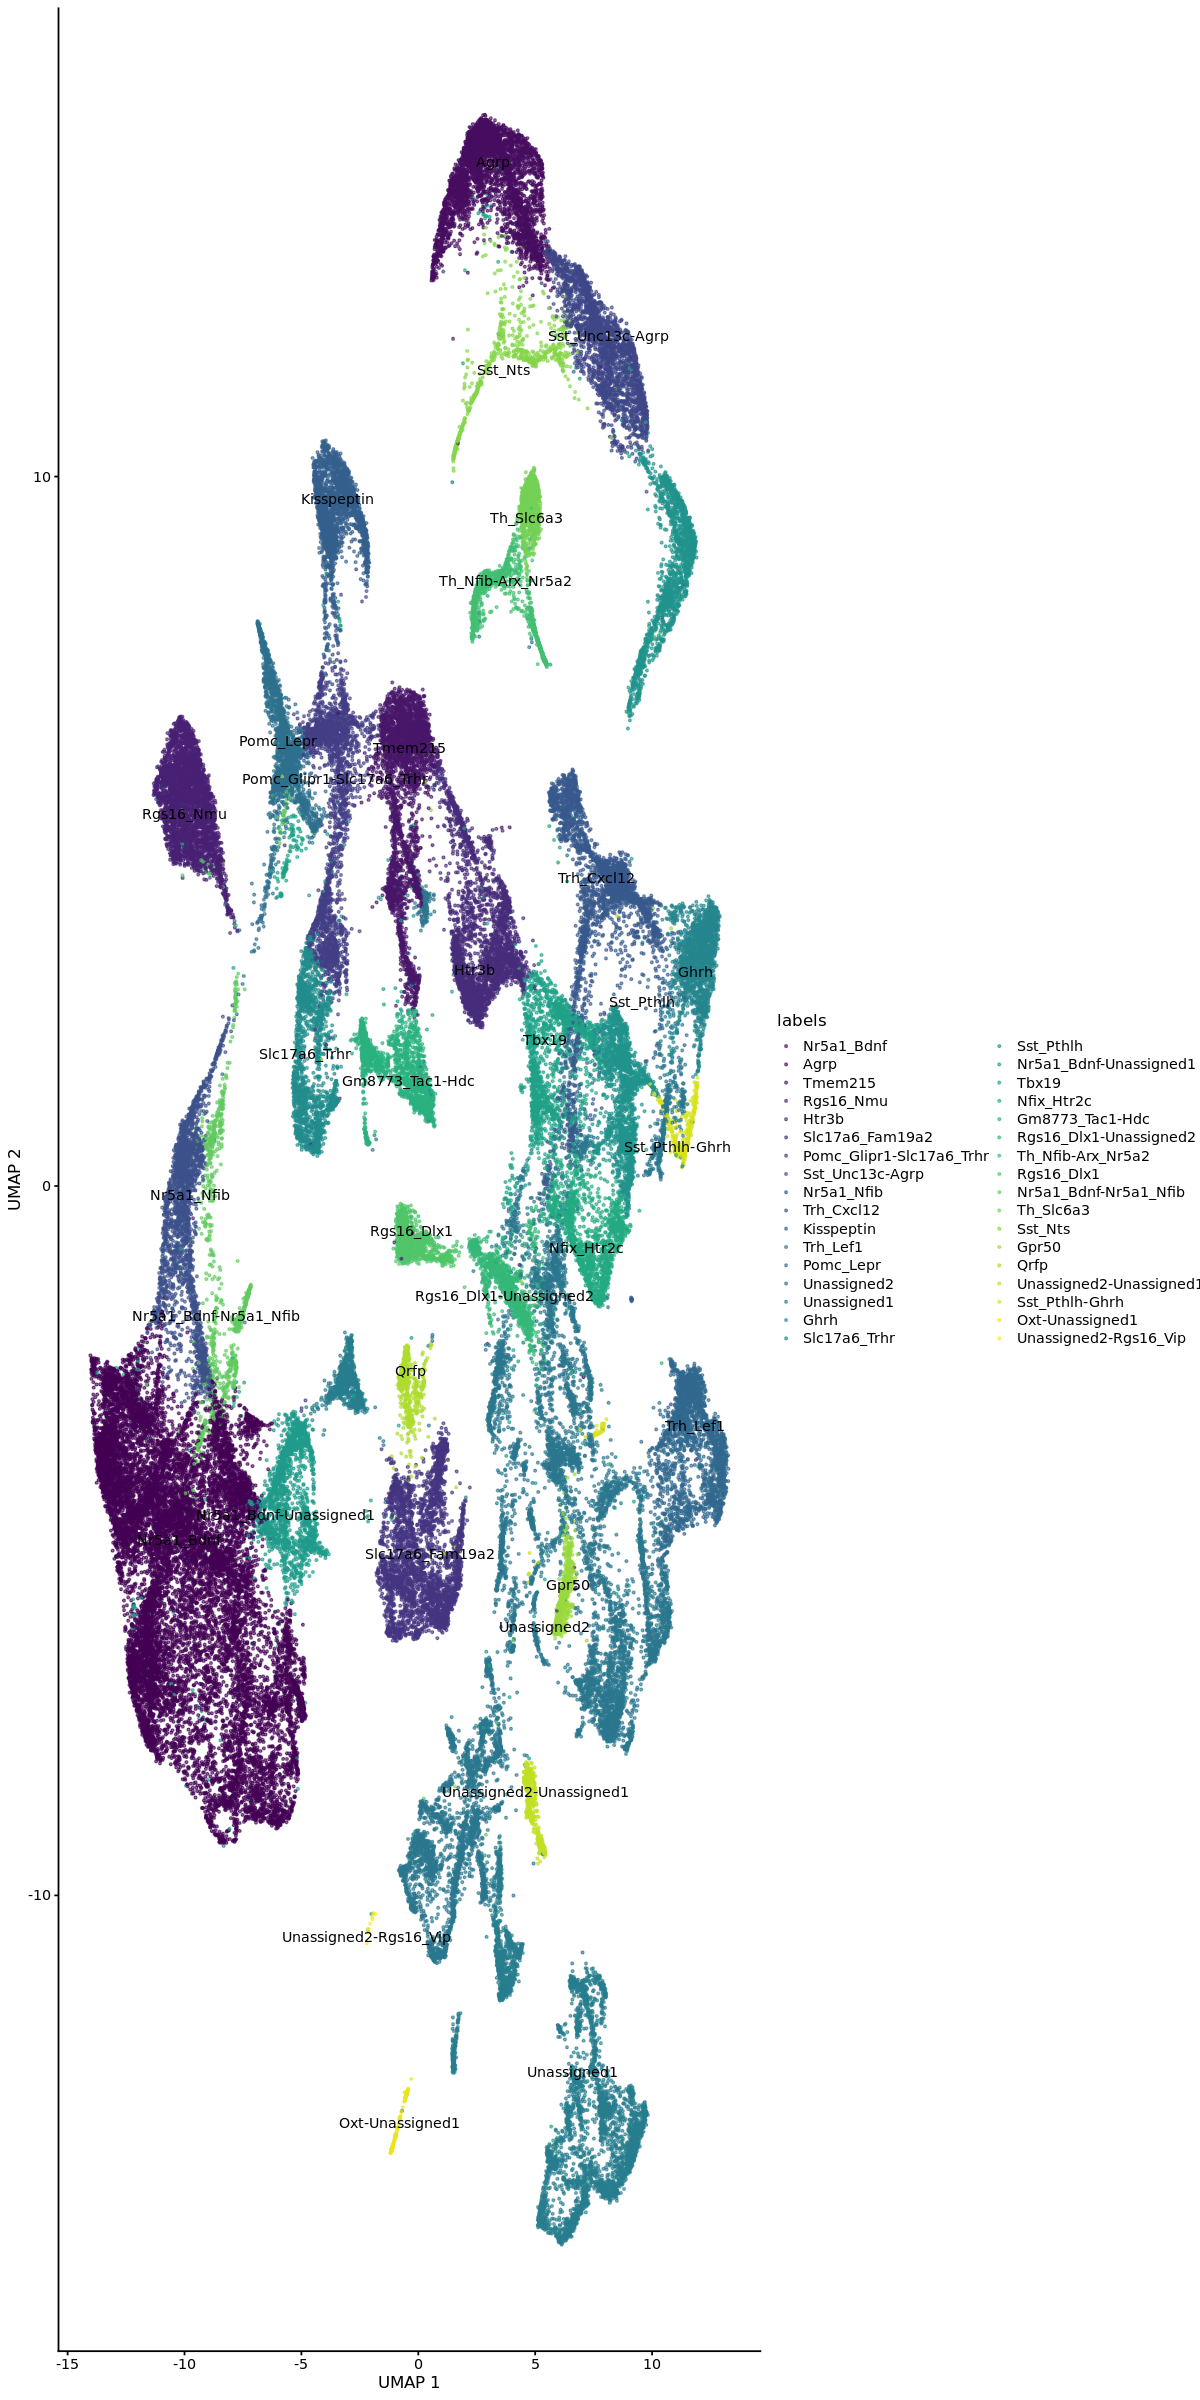

In [86]:
umap_pl

In [87]:
nh_graph_pl <- plotNhoodGraphDA(obob_milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2)) 

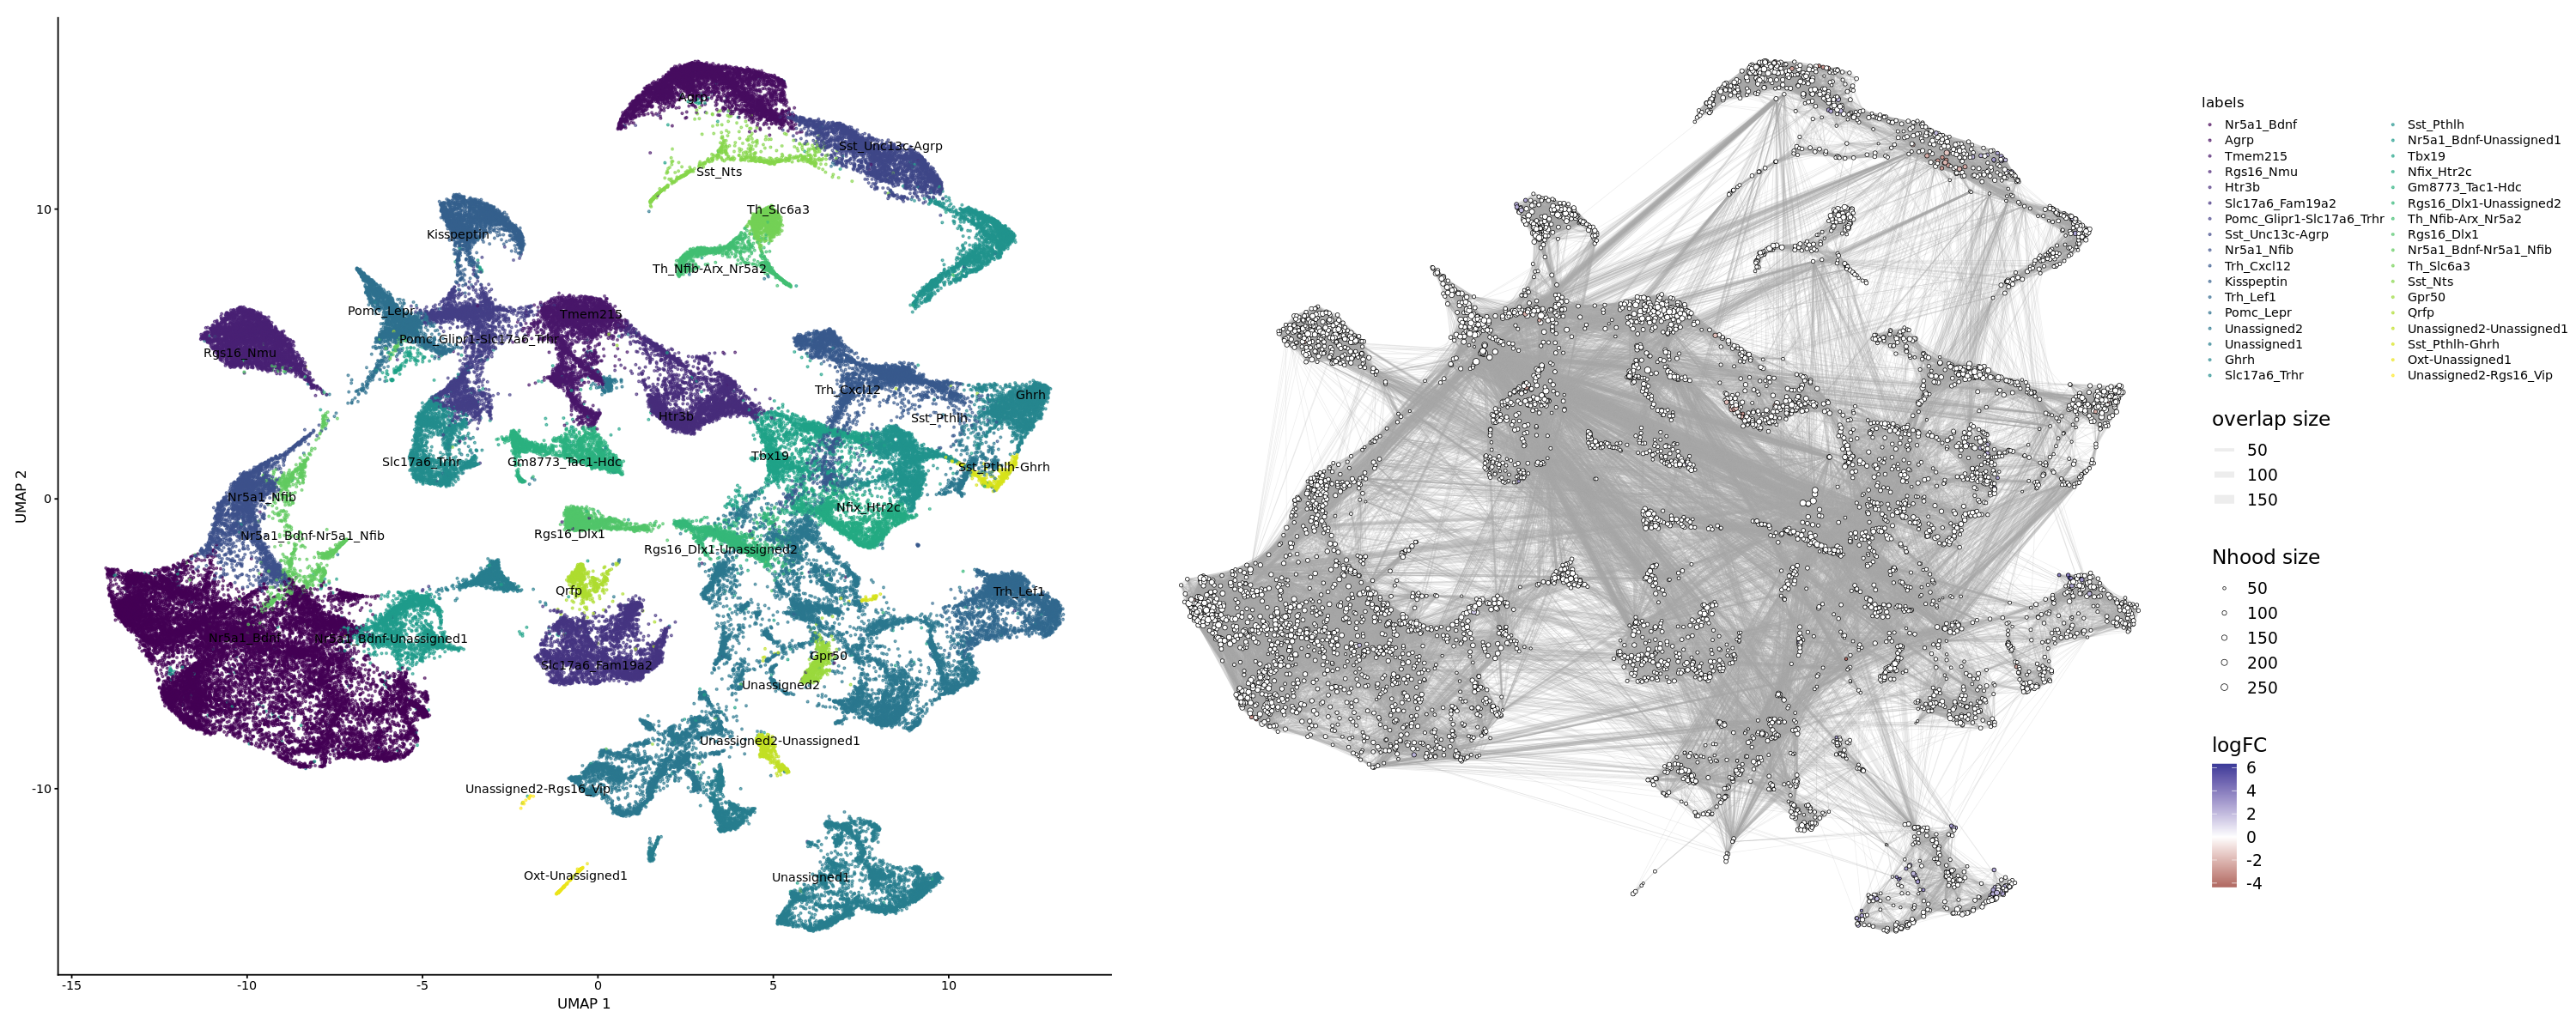

In [88]:
options(repr.plot.width=25, repr.plot.height=10)
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [89]:
da_results <- annotateNhoods(obob_milo, da_results, coldata_col = "labels")
head(da_results)

logFC       logCPM   F           PValue     FDR       Nhood SpatialFDR labels                 labels_fraction
1 -0.01809903 8.044026 0.001220262 0.97224760 0.9957352 1     0.9945884  Htr3b                  0.9770115      
2 -0.42746087 8.065794 0.186545322 0.66948800 0.9027586 2     0.9067563  Unassigned1            1.0000000      
3 -0.71691091 8.366017 2.457563083 0.12212307 0.5230172 3     0.5357539  Rgs16_Dlx1-Unassigned2 0.9512195      
4  0.38797178 8.077839 0.399542192 0.52968310 0.8500279 4     0.8578893  Nr5a1_Bdnf-Nr5a1_Nfib  1.0000000      
5  0.13679337 8.058968 0.040229906 0.84170702 0.9663164 5     0.9669457  Sst_Pthlh              1.0000000      
6 -1.15795155 7.994486 3.782707671 0.05638922 0.3817173 6     0.3971231  Rgs16_Nmu              1.0000000

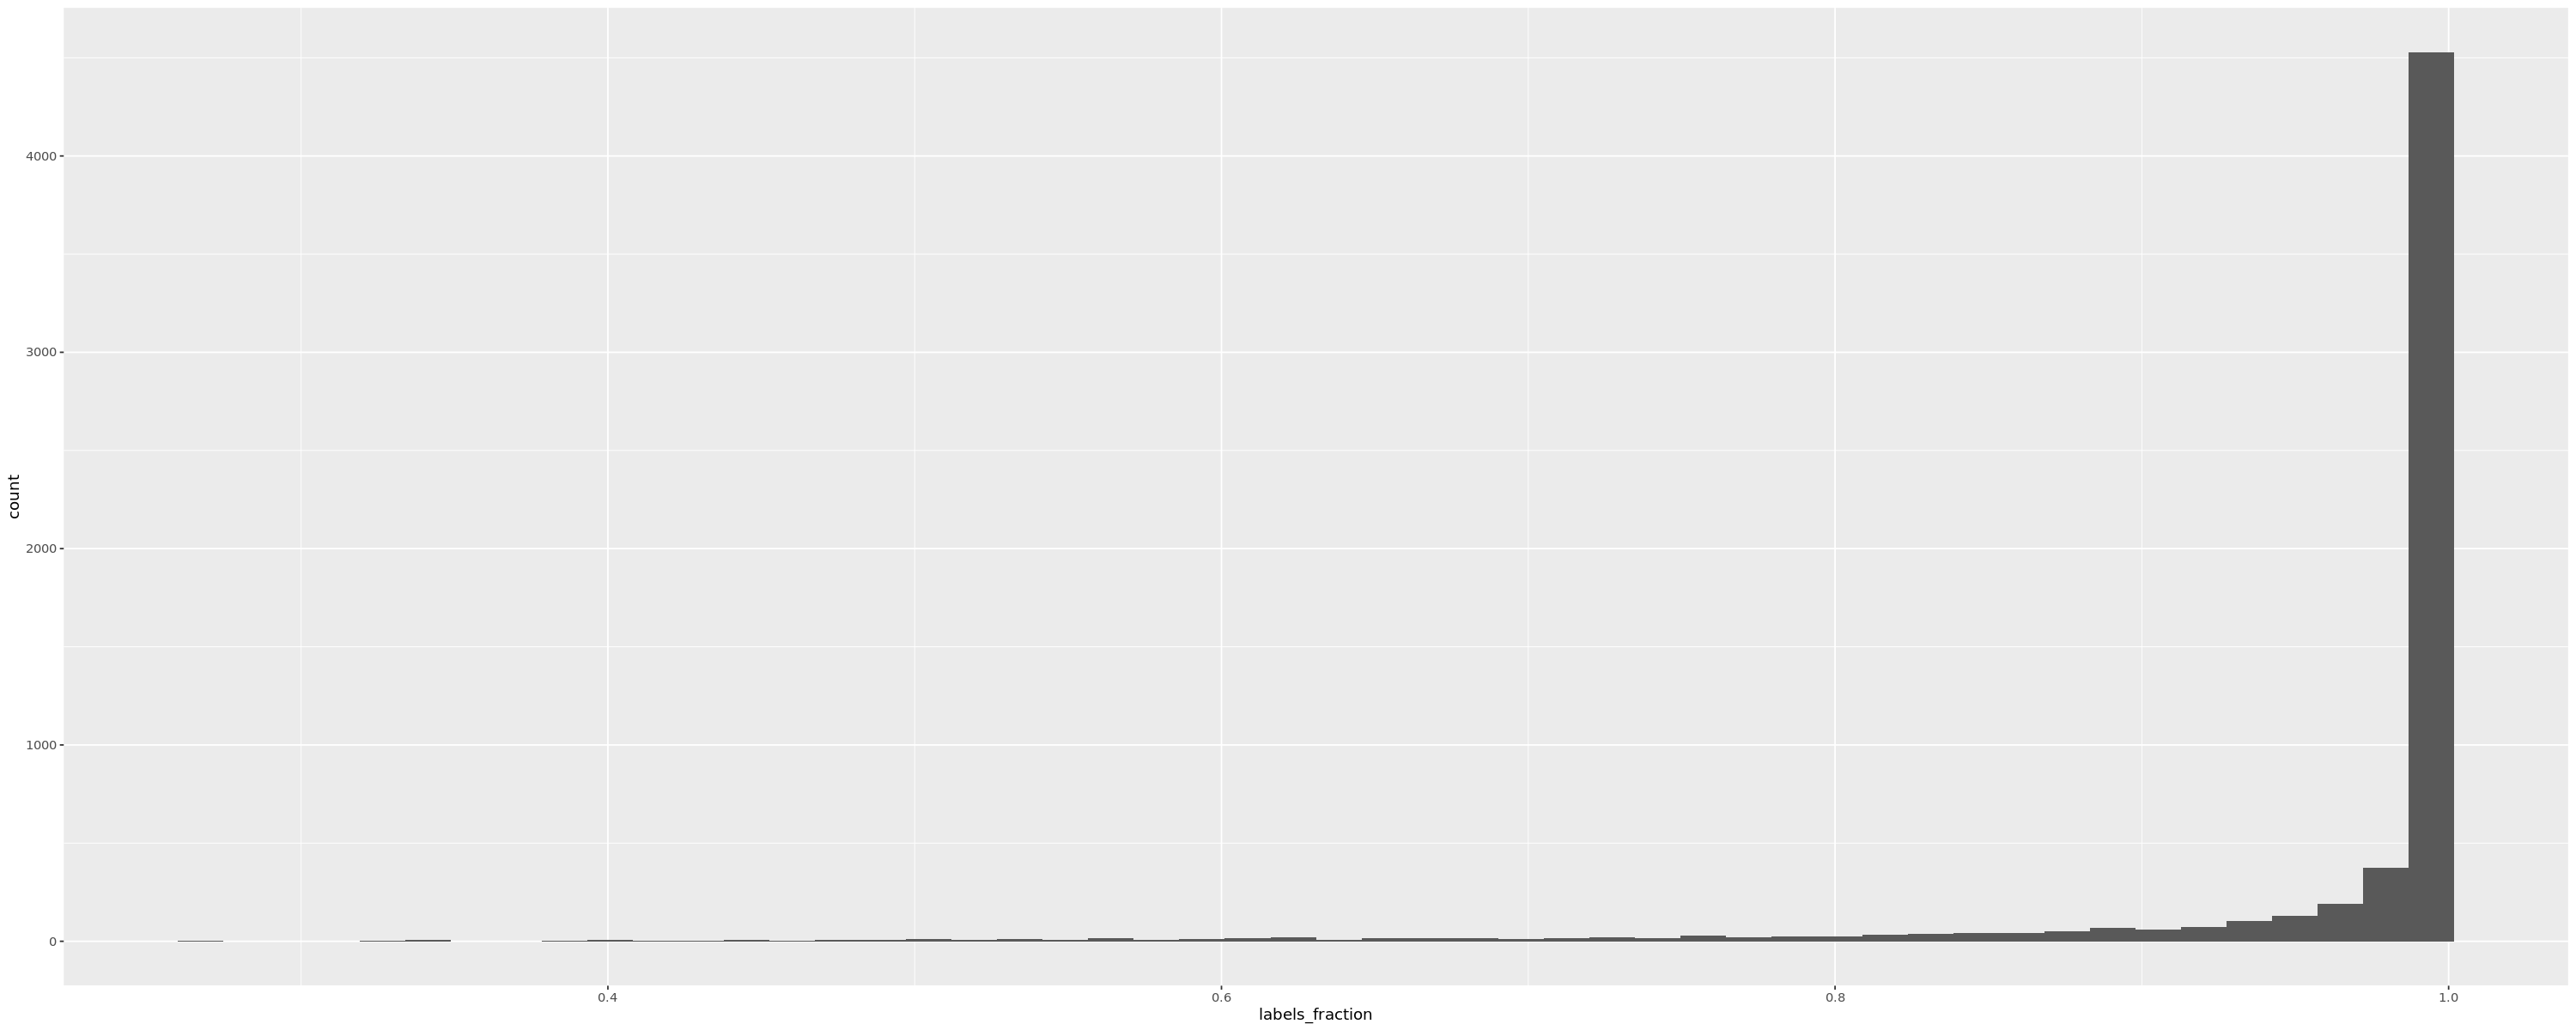

In [90]:
#we want to set a threshold to exclude neighbourhoods with a mix of cell types
ggplot(da_results, aes(labels_fraction)) + geom_histogram(bins=50)

In [91]:
da_results$labels <- ifelse(da_results$labels_fraction < 0.7, "Mixed", da_results$labels)

Converting group.by to factor...



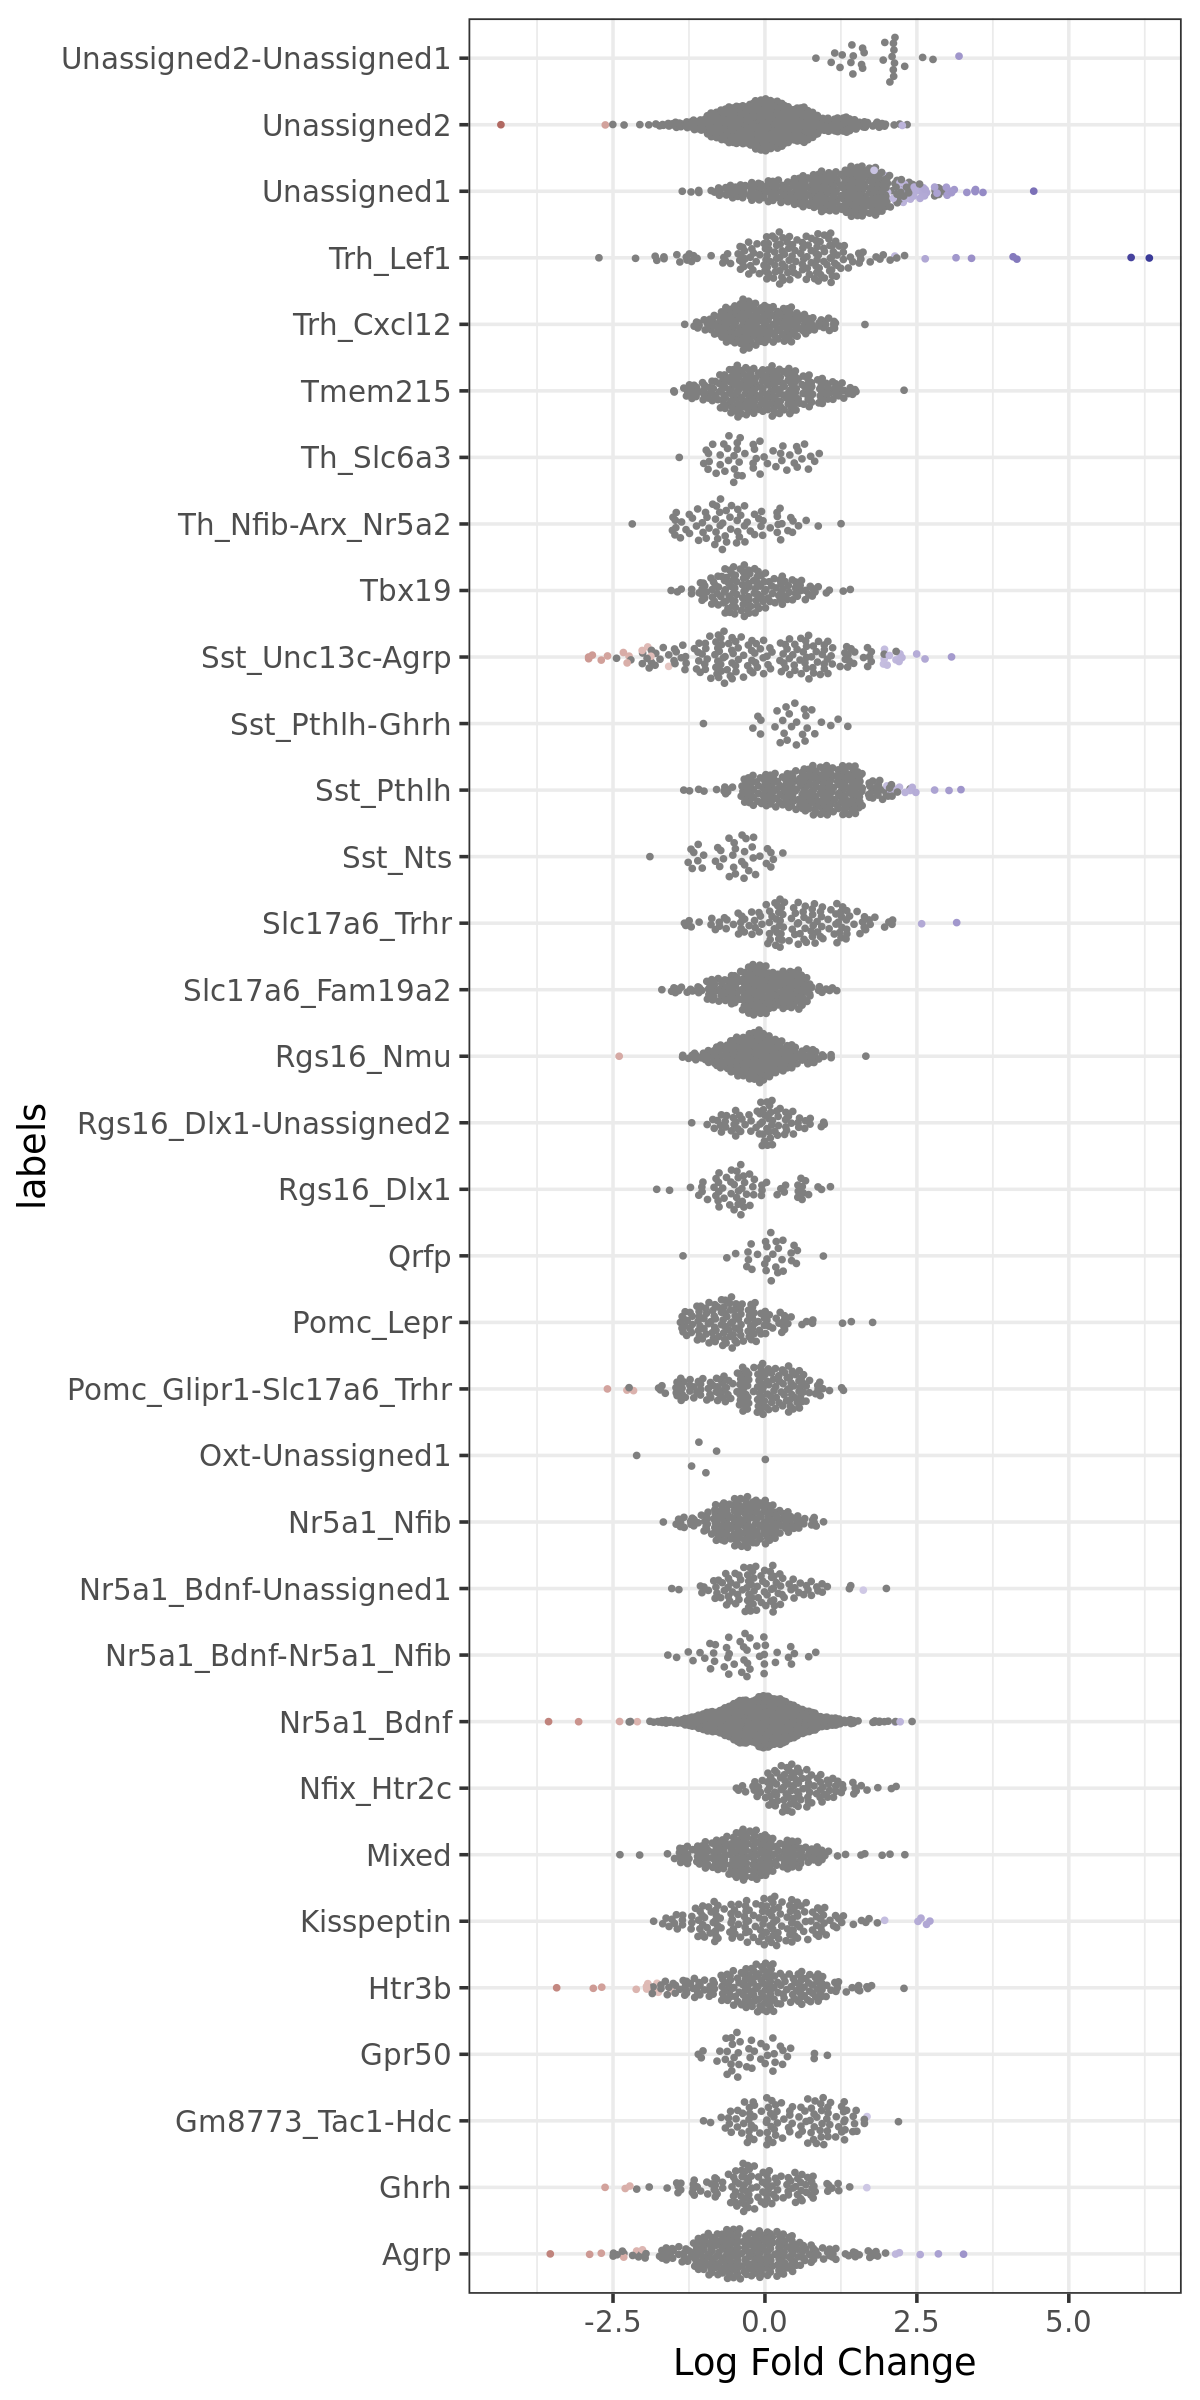

In [107]:
options(repr.plot.width=10, repr.plot.height=20)
plotDAbeeswarm(da_results, group.by = "labels")

In [93]:
da_results <- groupNhoods(obob_milo, da_results, max.lfc.delta = 10, )
head(da_results)

Found 130 DA neighbourhoods at FDR 10%

nhoodAdjacency found - using for nhood grouping



logFC       logCPM   F           PValue     FDR       Nhood SpatialFDR labels                 labels_fraction
1 -0.01809903 8.044026 0.001220262 0.97224760 0.9957352 1     0.9945884  Htr3b                  0.9770115      
2 -0.42746087 8.065794 0.186545322 0.66948800 0.9027586 2     0.9067563  Unassigned1            1.0000000      
3 -0.71691091 8.366017 2.457563083 0.12212307 0.5230172 3     0.5357539  Rgs16_Dlx1-Unassigned2 0.9512195      
4  0.38797178 8.077839 0.399542192 0.52968310 0.8500279 4     0.8578893  Nr5a1_Bdnf-Nr5a1_Nfib  1.0000000      
5  0.13679337 8.058968 0.040229906 0.84170702 0.9663164 5     0.9669457  Sst_Pthlh              1.0000000      
6 -1.15795155 7.994486 3.782707671 0.05638922 0.3817173 6     0.3971231  Rgs16_Nmu              1.0000000      
  NhoodGroup
1 1         
2 2         
3 3         
4 4         
5 5         
6 6

In [100]:
da_results %>% pull('NhoodGroup') %>% unique()

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "20" "21" "22" "23"
[24] "24" "25"

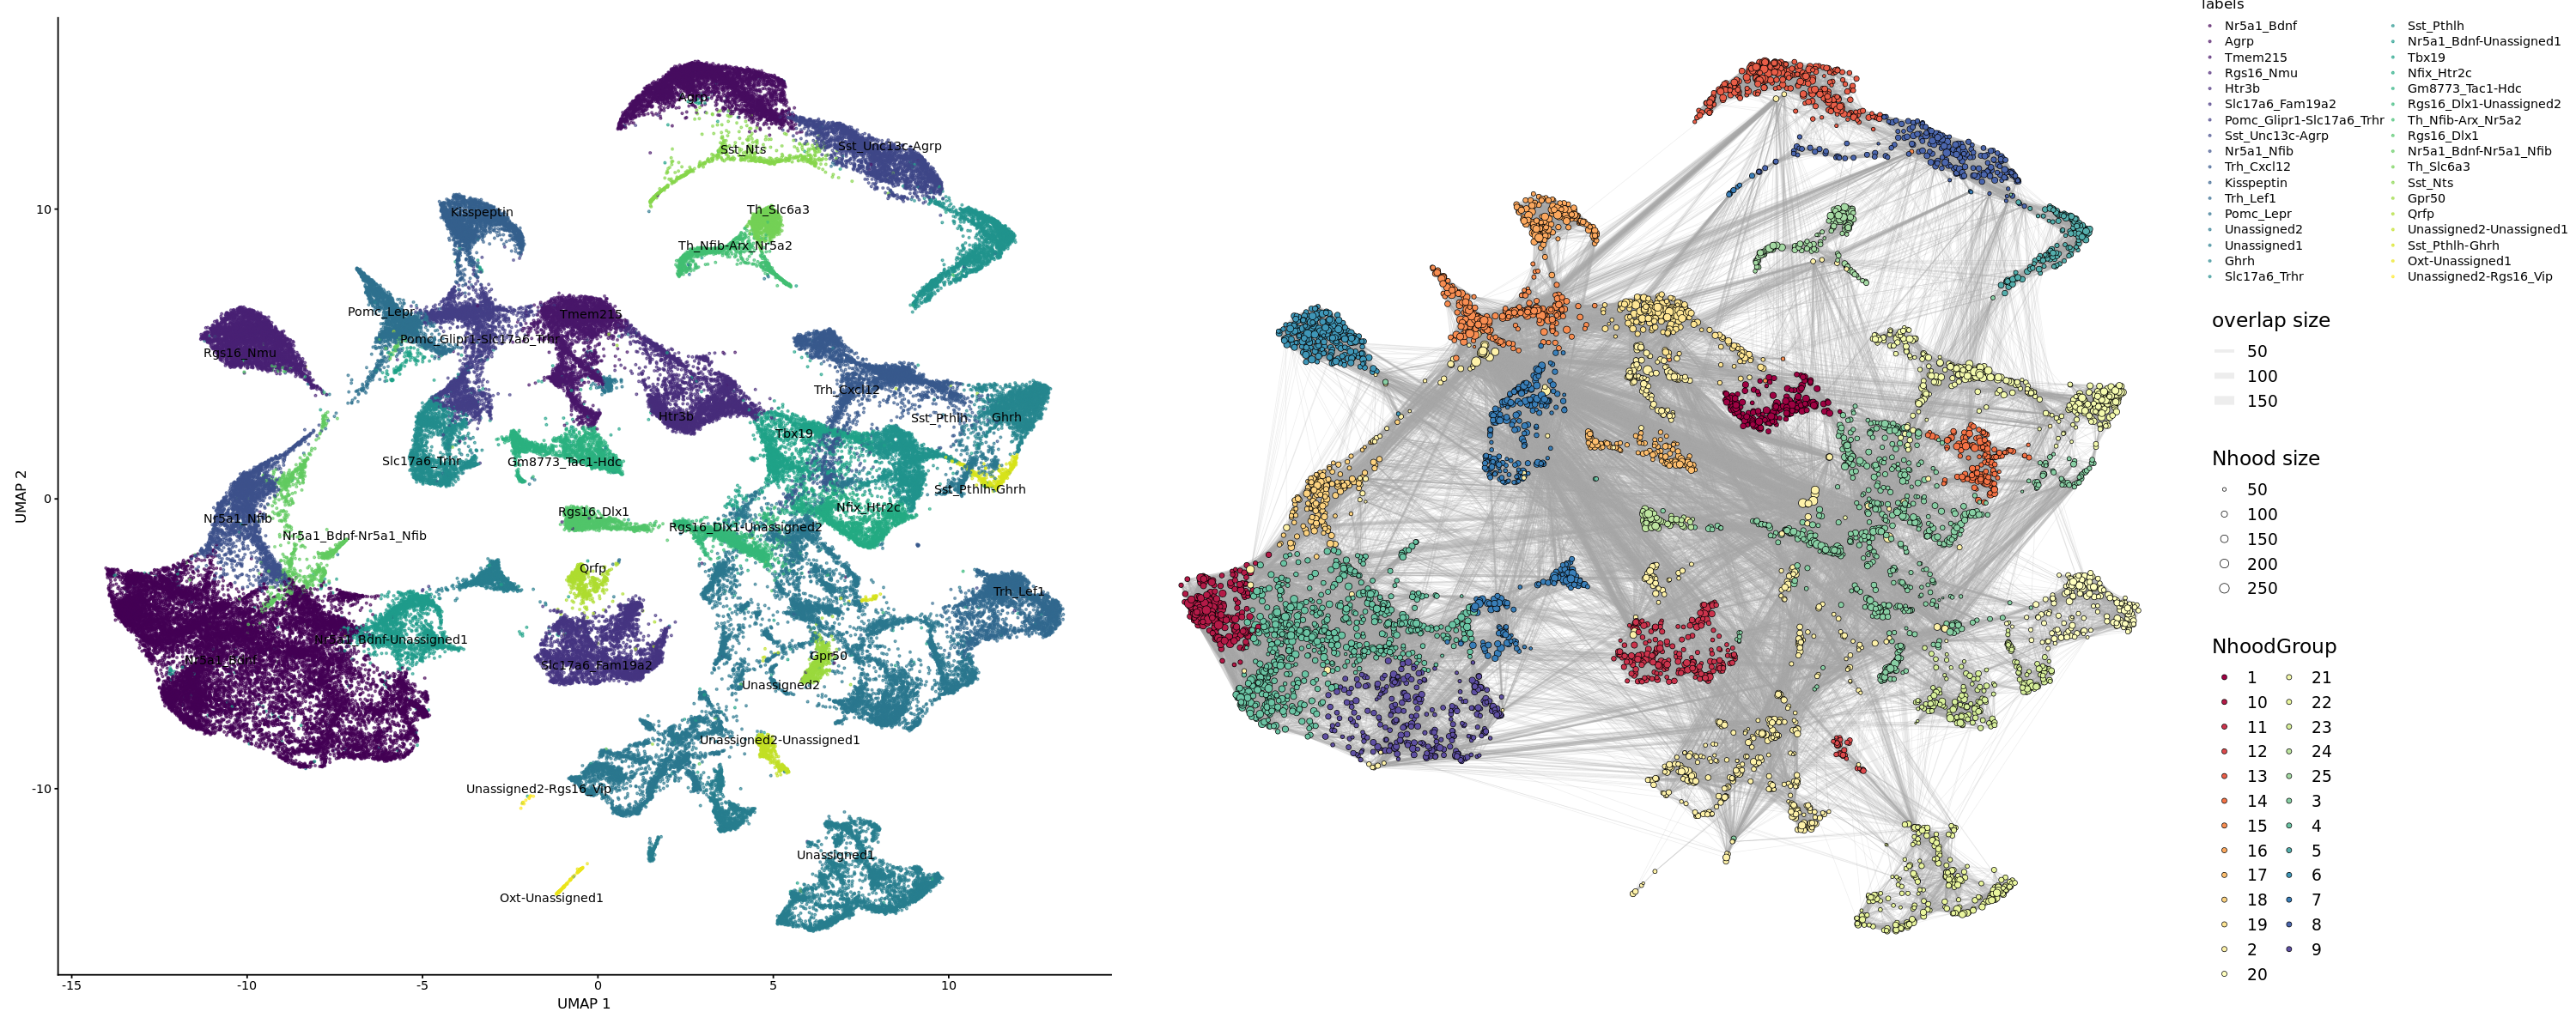

In [99]:
options(repr.plot.width=30, repr.plot.height=15)
nhood_groups_plot = plotNhoodGroups(obob_milo, da_results, layout="UMAP")
options(repr.plot.width=25, repr.plot.height=10)
umap_pl + nhood_groups_plot +
  plot_layout(guides="collect")

Converting group.by to factor...



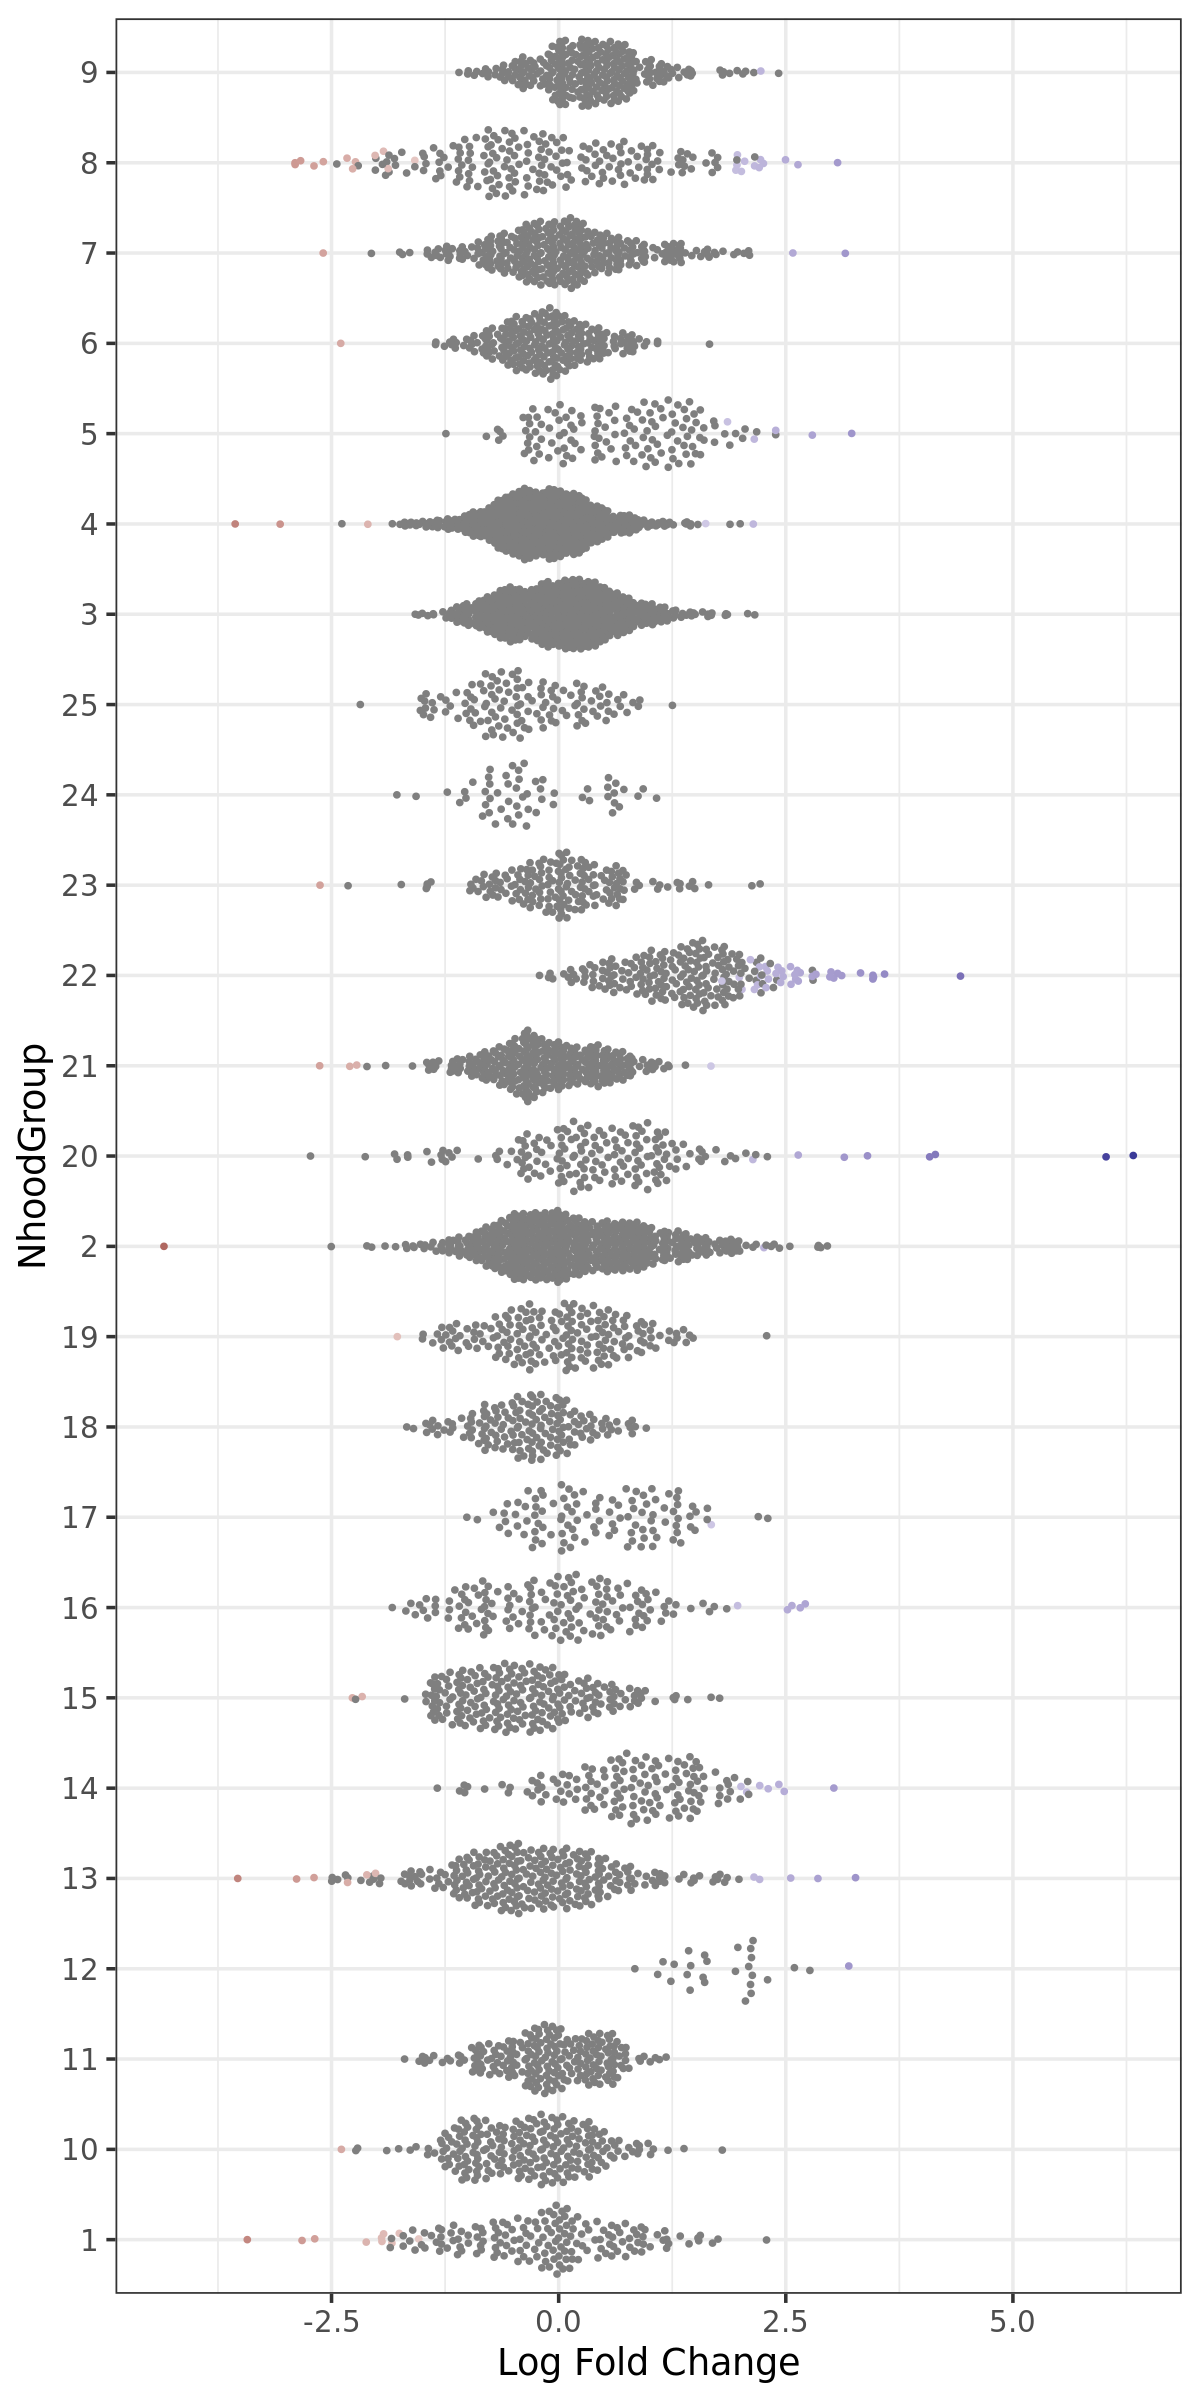

In [102]:
options(repr.plot.width=10, repr.plot.height=20)
plotDAbeeswarm(da_results, group.by = "NhoodGroup")

In [114]:
## Exclude zero counts genes
keep.rows <- rowSums(logcounts(obob_milo)) != 0
obob_milo <- obob_milo[keep.rows, ]

## Find HVGs
set.seed(101)
dec <- scran::modelGeneVar(obob_milo)
hvgs <- scran::getTopHVGs(dec, n=2000)
head(hvgs)

[1] "Erbb4"    "Hs3st4"   "Il1rapl2" "Cntn5"    "Nrxn3"    "Galntl6"

In [115]:
2

[1] 2

In [116]:
set.seed(42)
nhood_markers <- findNhoodGroupMarkers(obob_milo, da_results, subset.row = hvgs, 
                                       aggregate.samples = TRUE, sample_col = 'hash.mcl.ID')

head(nhood_markers)

GeneID        logFC_1      adj.P.Val_1  logFC_2     adj.P.Val_2 logFC_3      adj.P.Val_3 logFC_4     adj.P.Val_4 
1 0610040F04Rik  0.006971867 7.230653e-01  0.01953723 0.40605786   0.010847149 0.66843004   0.09315952 2.058809e-07
2 1110019D14Rik  0.128345049 3.557105e-04  0.04438203 0.33395894  -0.075532130 0.08068277   0.17158672 1.716823e-06
3 1500009L16Rik -0.100424945 1.968719e-02 -0.08379956 0.09653703  -0.112173119 0.02309707  -0.11442309 8.395097e-03
4 1600020E01Rik  0.107396228 3.317267e-05 -0.03386883 0.30497816  -0.004772035 0.90449585  -0.03042170 2.787921e-01
5 1700012D14Rik  0.046900114 1.342427e-01 -0.01791978 0.67615152  -0.011375540 0.80087314  -0.09444872 2.099507e-03
6 1700025G04Rik -0.137226904 3.187549e-02  0.04797170 0.57532756   0.029071193 0.75174409  -0.15018699 2.045663e-02
  logFC_5     ⋯ logFC_21     adj.P.Val_21 logFC_22    adj.P.Val_22 logFC_23     adj.P.Val_23 logFC_24    adj.P.Val_24
1  0.06538463 ⋯ -0.065795150 3.299741e-04  0.04401170 1.932149e-02  0.055857389 0.002636478  -0.03493221 6.016164e-02
2  0.01009527 ⋯ -0.188716594 1.355892e-07  0.12303544 8.323209e-04  0.002198044 0.957794235  -0.10360493 4.546152e-03
3  0.14074293 ⋯  0.004199212 9.330212e-01 -0.10424935 1.766311e-02 -0.088589800 0.045957996  -0.12142533 4.608302e-03
4 -0.02879592 ⋯  0.061268795 2.257676e-02 -0.06491785 1.632727e-02 -0.055544283 0.042052160   0.02143434 4.409774e-01
5 -0.29620473 ⋯  0.057154727 6.903637e-02 -0.11965267 9.422223e-05  0.087470594 0.004884333   0.01786905 5.839118e-01
6  0.10793025 ⋯ -0.495183893 2.485105e-16  0.14113174 3.061620e-02  0.179996244 0.005293901  -0.48376469 2.232119e-15
  logFC_25     adj.P.Val_25
1 -0.102646476 5.933475e-09
2 -0.095430907 8.598208e-03
3 -0.095264026 2.611551e-02
4  0.005272683 8.578277e-01
5  0.033602590 2.895060e-01
6  0.244243100 8.248705e-05

In [117]:
gr5_markers <- nhood_markers[c("logFC_5", "adj.P.Val_5")] 
colnames(gr5_markers) <- c("logFC", "adj.P.Val")

head(gr5_markers[order(gr5_markers$adj.P.Val), ])

logFC     adj.P.Val    
50   1.3125576  0.000000e+00
436  1.2076809  0.000000e+00
518  0.7855986 5.145555e-205
192  1.3218737 4.736423e-183
1762 1.6741677 7.245076e-183
1411 0.9678746 3.049817e-148

In [120]:
gr8_markers <- nhood_markers[c("GeneID", "logFC_8", "adj.P.Val_8")] 
colnames(gr8_markers) <- c("GeneID", "logFC", "adj.P.Val")

head(gr8_markers[order(gr8_markers$adj.P.Val), ])

GeneID   logFC     adj.P.Val    
1833 Tmem26   1.0741504 7.547538e-182
1389 Prkch    0.4636324 7.039400e-119
1443 Radx     0.4918065  1.888413e-82
1977 Zfp521   1.0802866  1.917311e-46
1566 Serpini1 0.8508309  6.821037e-45
184  B4galt1  0.4122155  7.767839e-45